In [39]:
from typing import Optional, Tuple, Union

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from master_thesis.utils.loading import ConnectivityDataset, balance_split_dataset
from master_thesis.utils.plotting import plot_confusion_matrix

# Constants and hyperparameters

In [2]:
# Constants
EC_DATASET_PATH = "/Users/wciezobka/sano/projects/masters-thesis/Datasets/NeuroFlicks/networks"
CAUSAL_COEFF_THRESHOLD = 0.5

# Hyperparameters
TEST_FRACTION = 0.5
N_BINS = 10
# EPOCHS = 100
# BATCH_SIZE = 32
# LEARNING_RATE = 2e-3
# WEIGHT_DECAY = 5e-4
# NUM_LAYERS = 2
# HIDDEN_SIZE = 16

# Data handling

## Load effective connectivity data

In [3]:
dataset = ConnectivityDataset(EC_DATASET_PATH, causal_coeff_threshold=0.5, ldp=True)

/Users/wciezobka/venvs/sano/lib/python3.10/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


## Aggregate LDPs

In [4]:
def aggregate_ldp(data: Data) -> np.ndarray:
    ldp = data.x
    x = [np.histogram(ldp[:, i], bins=N_BINS, density=True)[0] for i in range(5)]
    return np.concatenate(x, axis=0)

In [5]:
xs = []
ys = []
for data in dataset:
    x = aggregate_ldp(data)
    xs.append(x)
    ys.append(data.y.item())
xs = np.stack(xs, axis=0)
ys = np.array(ys)

In [16]:
len(ys) - np.sum(ys), np.sum(ys)

(69, 380)

## Train/test split

In [18]:
half_test_size = 19
xs_train, ys_train, xs_test, ys_test = balance_split_dataset(xs, ys, half_test_size=half_test_size, verbose=True)

X_train shape: (722, 50), y_train shape: (722,)
X_test shape: (38, 50), y_test shape: (38,)
Ratio of positive samples in train: 0.5
Ratio of positive samples in test: 0.5


## Model training

In [87]:
# model = RandomForestClassifier(
#     n_estimators=1,
#     criterion="gini",
#     max_features="sqrt",
#     n_jobs=-1,
#     random_state=0,
# )

# model = LinearSVC(
#     penalty="l2",
#     loss="hinge",
#     max_iter=10000,
#     random_state=0,
# )

# model = SVC(
#     kernel="rbf",
#     cache_size=1024,
#     random_state=0,
#     C=1.
# )

model = MLPClassifier(
    hidden_layer_sizes=(4, 4),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    batch_size="auto",
    learning_rate="constant",
    learning_rate_init=0.001,
    max_iter=10000,
    random_state=0,
)

In [88]:
model.fit(xs_train, ys_train)

MLPClassifier(hidden_layer_sizes=(4, 4), max_iter=10000, random_state=0)

In [89]:
ys_hat_train = model.predict(xs_train)
ys_hat_test = model.predict(xs_test)

## Model evaluation

Train
Accuracy: 0.9889196675900277
Precision: 1.0
Recall: 0.9778393351800554
F1: 0.988795518207283

Test
Accuracy: 0.6578947368421053
Precision: 0.6153846153846154
Recall: 0.8421052631578947
F1: 0.7111111111111111


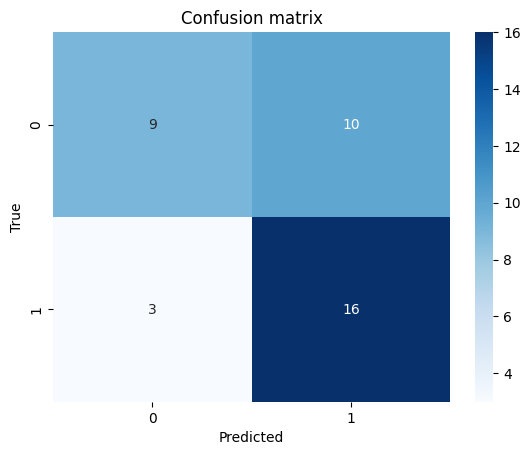

In [90]:
# Train metrics
print("Train")
print(f"Accuracy: {accuracy_score(ys_train, ys_hat_train)}")
print(f"Precision: {precision_score(ys_train, ys_hat_train)}")
print(f"Recall: {recall_score(ys_train, ys_hat_train)}")
print(f"F1: {f1_score(ys_train, ys_hat_train)}")

# Test metrics
print("\nTest")
print(f"Accuracy: {accuracy_score(ys_test, ys_hat_test)}")
print(f"Precision: {precision_score(ys_test, ys_hat_test)}")
print(f"Recall: {recall_score(ys_test, ys_hat_test)}")
print(f"F1: {f1_score(ys_test, ys_hat_test)}")

# Plot confusion matrix
plot_confusion_matrix(ys_test, ys_hat_test)